In [1]:
import pandas as pd
import geopandas

from tqdm import tqdm
from shapely.geometry import Point
from geopy.distance import great_circle
from scipy import stats
from multiprocessing import Pool

/Users/dclure/.local/share/virtualenvs/us-pop-density-BOzJjxpF/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/dclure/.local/share/virtualenvs/us-pop-density-BOzJjxpF/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [3]:
df = pd.read_table('../data/Gaz_places_national.txt', encoding='ISO-8859-1')

In [4]:
df.head(10)

,USPS,GEOID,ANSICODE,NAME,LSAD,FUNCSTAT,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,100100,2582661,Abanda CDP,57,S,192,79,7764035,34284,2.998,0.013,33.091627,-85.527029
1,AL,100124,2403054,Abbeville city,25,A,2688,1255,40255352,107642,15.543,0.042,31.564216,-85.259634
2,AL,100460,2403063,Adamsville city,25,A,4522,1990,65083153,29719,25.129,0.011,33.605750,-86.974650
3,AL,100484,2405123,Addison town,43,A,758,351,9753286,83426,3.766,0.032,34.202689,-87.177901
4,AL,100676,2405125,Akron town,43,A,356,205,1778126,13850,0.687,0.005,32.879417,-87.741757
5,AL,100820,2403069,Alabaster city,25,A,30352,11295,64860720,747585,25.043,0.289,33.214355,-86.823080
6,AL,100988,2403074,Albertville city,25,A,21160,8128,68780663,258708,26.556,0.100,34.263130,-86.210660
7,AL,101132,2403077,Alexander City city,25,A,14875,6834,105771865,737649,40.839,0.285,32.927240,-85.937122
8,AL,101180,2402638,Alexandria CDP,57,S,3917,1599,28786548,33123,11.115,0.013,33.765175,-85.879596
9,AL,101228,2403080,Aliceville city,25,A,2486,1164,11814094,0,4.561,0.000,33.123744,-88.159445


In [5]:
df['point'] = df.apply(lambda r: Point(r.INTPTLONG, r.INTPTLAT), axis=1)

In [6]:
df.head(10)

,USPS,GEOID,ANSICODE,NAME,LSAD,FUNCSTAT,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG,point
0,AL,100100,2582661,Abanda CDP,57,S,192,79,7764035,34284,2.998,0.013,33.091627,-85.527029,POINT (-85.527029 33.091627)
1,AL,100124,2403054,Abbeville city,25,A,2688,1255,40255352,107642,15.543,0.042,31.564216,-85.259634,POINT (-85.25963399999999 31.564216)
2,AL,100460,2403063,Adamsville city,25,A,4522,1990,65083153,29719,25.129,0.011,33.605750,-86.974650,POINT (-86.97465 33.60575)
3,AL,100484,2405123,Addison town,43,A,758,351,9753286,83426,3.766,0.032,34.202689,-87.177901,POINT (-87.17790100000001 34.202689)
4,AL,100676,2405125,Akron town,43,A,356,205,1778126,13850,0.687,0.005,32.879417,-87.741757,POINT (-87.74175699999999 32.879417)
5,AL,100820,2403069,Alabaster city,25,A,30352,11295,64860720,747585,25.043,0.289,33.214355,-86.823080,POINT (-86.82308 33.214355)
6,AL,100988,2403074,Albertville city,25,A,21160,8128,68780663,258708,26.556,0.100,34.263130,-86.210660,POINT (-86.21066 34.26313)
7,AL,101132,2403077,Alexander City city,25,A,14875,6834,105771865,737649,40.839,0.285,32.927240,-85.937122,POINT (-85.937122 32.92724)
8,AL,101180,2402638,Alexandria CDP,57,S,3917,1599,28786548,33123,11.115,0.013,33.765175,-85.879596,POINT (-85.87959599999999 33.765175)
9,AL,101228,2403080,Aliceville city,25,A,2486,1164,11814094,0,4.561,0.000,33.123744,-88.159445,POINT (-88.15944499999999 33.123744)


In [7]:
gdf = geopandas.GeoDataFrame(df, geometry='point')

In [8]:
states = geopandas.read_file('../data/cb_2017_us_state_5m/cb_2017_us_state_5m.shp')

In [9]:
def plot_state(state):
    ax = states[states.STUSPS==state].plot(color='white', edgecolor='black', figsize=(20,20))
    sdf = gdf[gdf.USPS==state]
    sdf.plot(ax=ax, color='blue', markersize=sdf['POP10'] / 200, alpha=0.3)

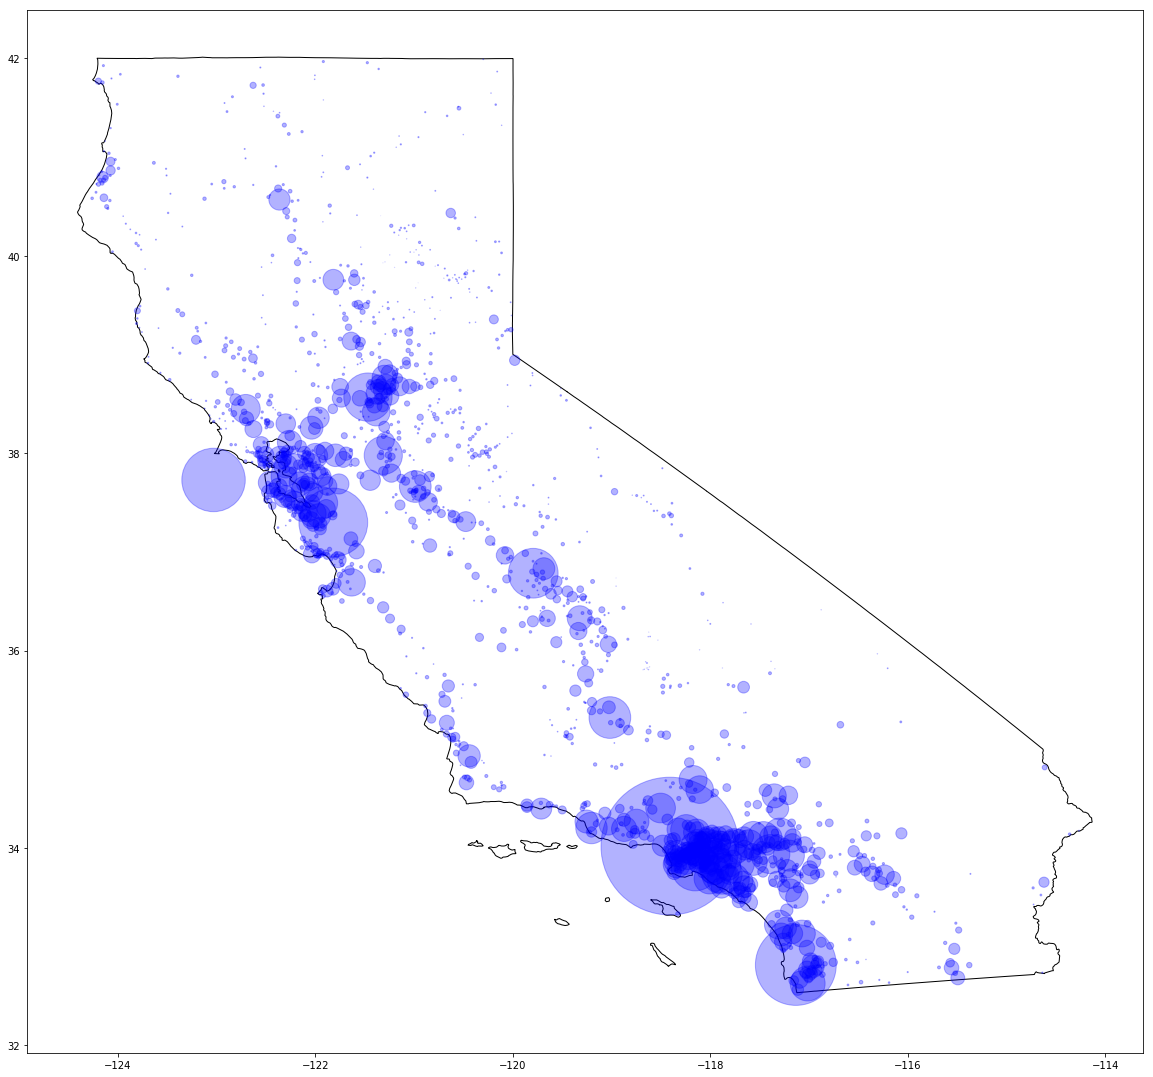

In [10]:
plot_state('CA')

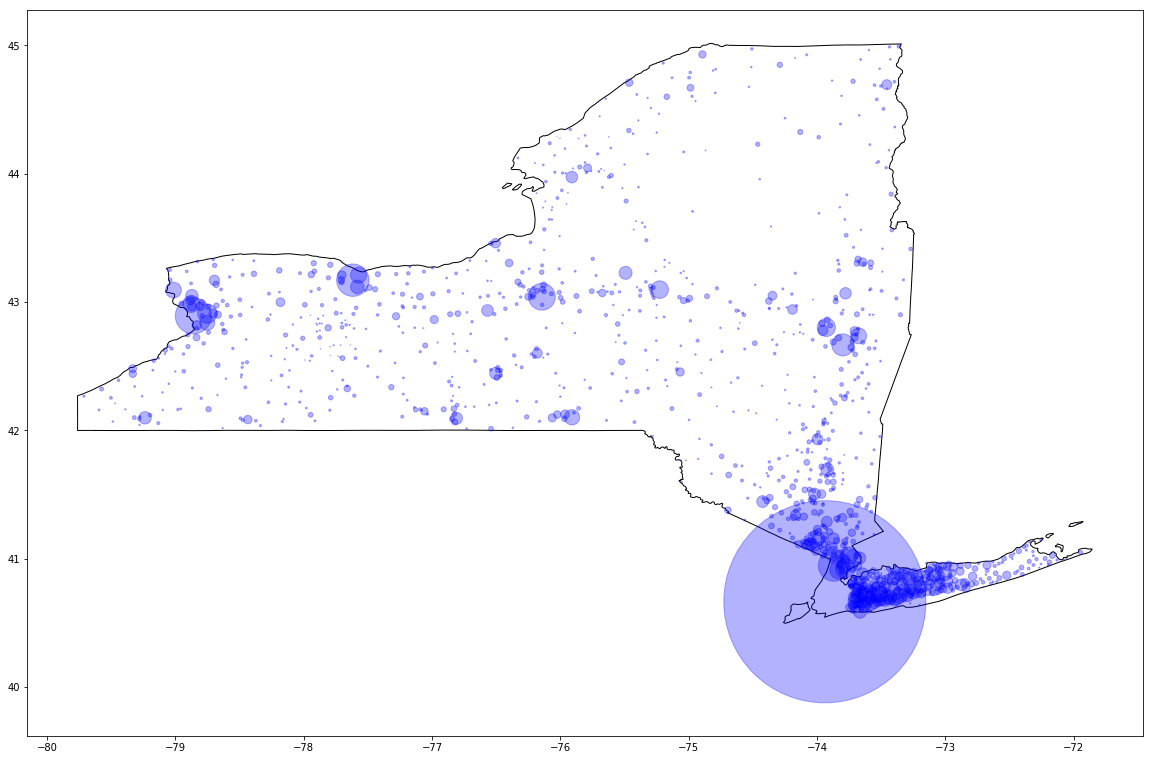

In [11]:
plot_state('NY')

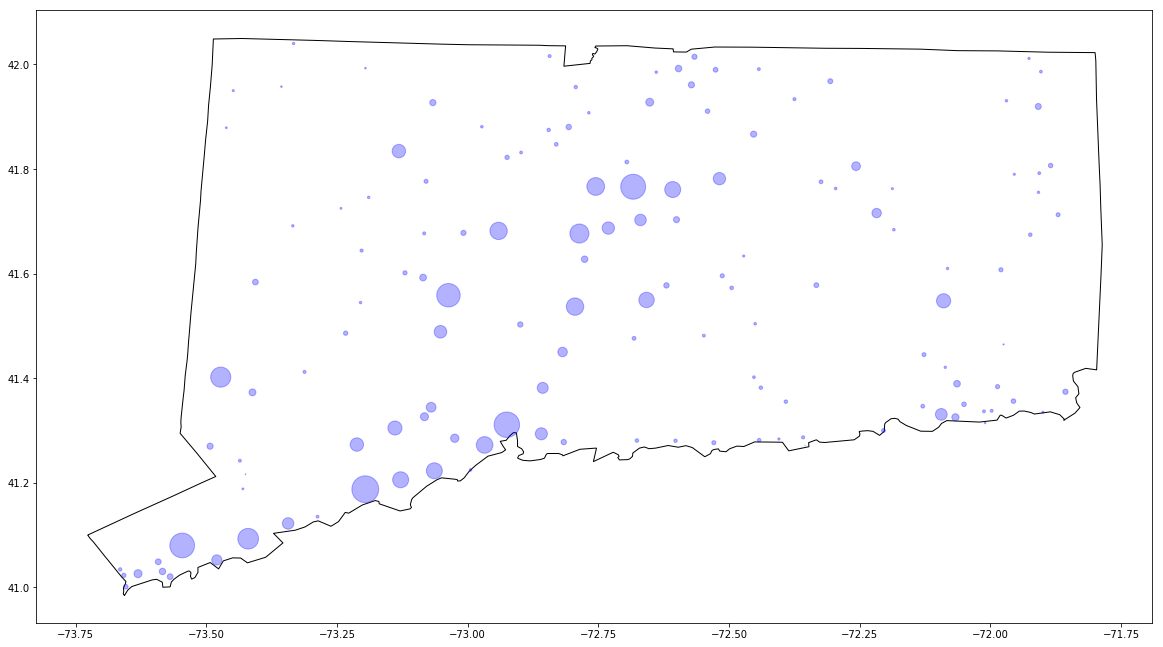

In [17]:
plot_state('CT')

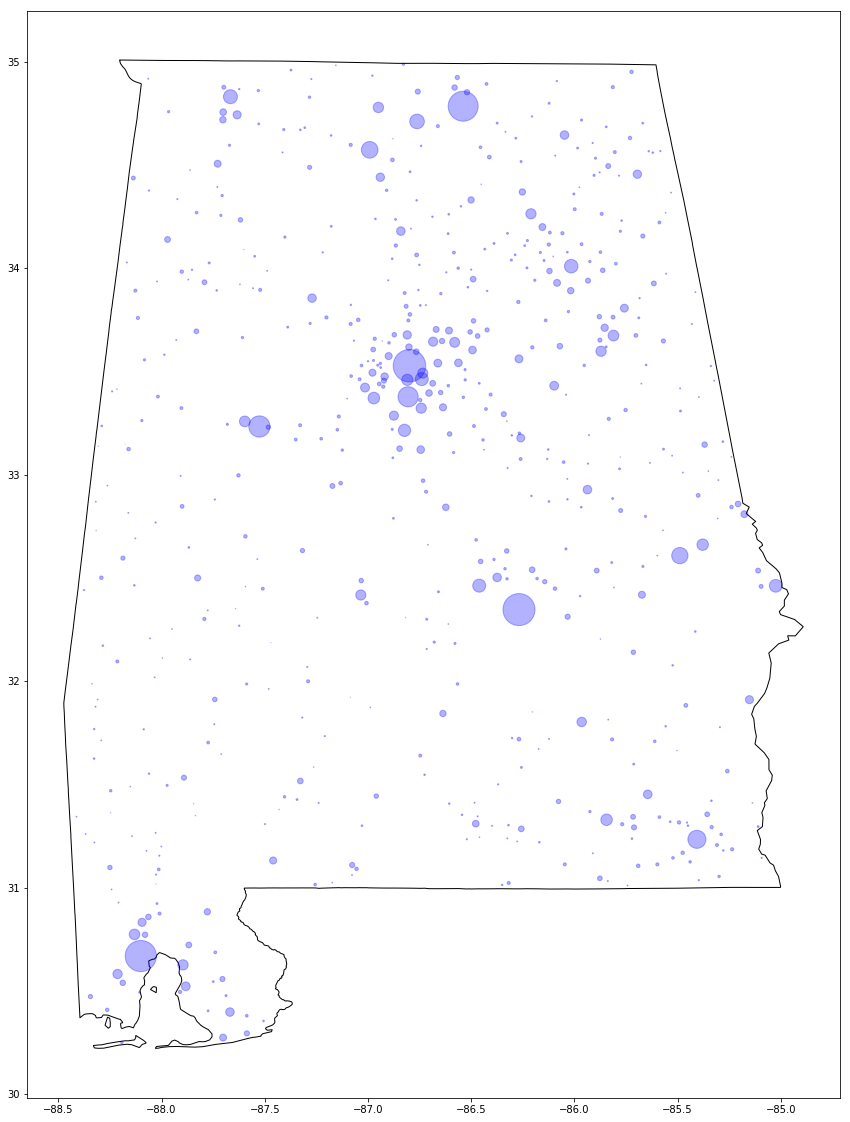

In [12]:
plot_state('AL')

In [13]:
def t_weight(c_lat, c_lon, t_lat, t_lon, t_pop, std=20):
    d = great_circle((c_lat, c_lon), (t_lat, t_lon)).miles
    w = stats.norm.pdf(d, 0, std)
    return w * t_pop

In [14]:
cities = [
    (r.INTPTLAT, r.INTPTLONG, r.POP10)
    for r in df.itertuples()
]

In [15]:
def score(idx_c):
    idx, c = idx_c
    s = 0
    for t in cities:
        s += t_weight(c.INTPTLAT, c.INTPTLONG, *t)
    return idx, s

In [16]:
with Pool() as p:
    rows = []
    for idx, s in p.imap_unordered(score, tqdm(list(df.iterrows()))):
        rows.append((idx, s))

  2%|▏         | 682/29514 [10:57<7:43:36,  1.04it/s]Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [256]:
rows

[(1, 1711.0065346431297),
 (4, 1446.6173882361134),
 (6, 3748.1121978944993),
 (5, 10240.289623025974),
 (7, 2255.5754446400015),
 (3, 2282.5068127739137),
 (0, 1973.6678221169198),
 (2, 11490.00057094958)]